# PULSAR DETECTION
----
**Author:** Gosaye Emshaw  
**Date:** 10/7/2025  

----

----
# 1. Introduction

----
In the Exploratory Data Analysis (EDA) phase, we conducted a comprehensive statistical and visual examination of the dataset to uncover underlying structures, relationships, and potential data quality issues. Specifically, we explored:

- Descriptive statistics to understand the central tendency and dispersion of each feature.
- Target variable analysis to assess the class distribution and identify the degree of imbalance.
- Feature distribution analysis, both globally and class-wise, to examine how each feature behaves across pulsar and non-pulsar observations.
- Correlation analysis to evaluate multicollinearity and detect redundant or strongly related variables.
- Outlier detection using the interquartile range (IQR) method to identify potential anomalies that could distort model learning.

From these investigations, we concluded that the dataset requires feature engineering interventions to improve data quality and enhance model performance. Specifically, we recommended the transformation and scaling of features, experimentation with derived (interaction) features, and potentially revisiting outlier treatment to achieve more stable predictive behavior.

----
In this notebook, we will Experiment and evaluate several feature engineering approaches designed to improve model robustness and generalization. These steps include:

**1. Feature Scaling:**  
Apply normalization and standardization techniques to ensure features operate on comparable numerical ranges, preventing model bias toward features with larger magnitudes.

**2. Feature Transformation:**  
Use mathematical transformations to address skewness, reduce variance, and approximate normal distributions where appropriate.

**3. Feature Interaction and Construction:**  
Explore potential feature interactions or ratios that may capture nonlinear relationships and enhance discriminative power.

**4. Feature Selection:**  
Evaluate and retain only the most relevant features using statistical metrics, correlation thresholds, or model-based importance measures to mitigate overfitting and improve computational efficiency.

**5. Dataset Partitioning:**   
Split the dataset into training, validation, and test subsets to ensure unbiased model evaluation and fair generalization assessment.

----

One of the principal challenges in this dataset is the severe class imbalance, where the positive (pulsar) instances represent roughly 10% of the total observations. This imbalance can lead to biased model learning, where the model prioritizes the majority (non-pulsar) class and underperforms on the minority class.

----
# 2. Load Data
Let's Load the raw data and start our experiment!

----

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (StandardScaler, RobustScaler, MinMaxScaler, PowerTransformer)

FIG_PATH = "../reports/figures/"

In [2]:
print("Loading the raw dataset...")
column_names = [
    "Mean_IP", "SD_IP", "EK_IP", "SK_IP", 
    "Mean_DMSNR", "SD_DMSNR", "EK_DMSNR", "SK_DMSNR", 
    "Target_Class"
]
try:
    pulsar = pd.read_csv("../data/raw/HTRU_2.csv", names = column_names)
    print("The pulsar dataset loaded successfully!")
except Exception as e:
    print(f"Loading failed: {e}")

Loading the raw dataset...
The pulsar dataset loaded successfully!


In [3]:
print("Checking the dataset...")
print(f"* Shape: {pulsar.shape}")
print(f"\n* First 5 rows: \n{pulsar.head()}")

Checking the dataset...
* Shape: (17898, 9)

* First 5 rows: 
      Mean_IP      SD_IP     EK_IP     SK_IP  Mean_DMSNR   SD_DMSNR  \
0  140.562500  55.683782 -0.234571 -0.699648    3.199833  19.110426   
1  102.507812  58.882430  0.465318 -0.515088    1.677258  14.860146   
2  103.015625  39.341649  0.323328  1.051164    3.121237  21.744669   
3  136.750000  57.178449 -0.068415 -0.636238    3.642977  20.959280   
4   88.726562  40.672225  0.600866  1.123492    1.178930  11.468720   

    EK_DMSNR    SK_DMSNR  Target_Class  
0   7.975532   74.242225             0  
1  10.576487  127.393580             0  
2   7.735822   63.171909             0  
3   6.896499   53.593661             0  
4  14.269573  252.567306             0  


----
# 3. Train/test Split

----
Before starting any experiment we have to split our dataset into train and test set, Then we will set aside the test set and we will use only once after chosing our final model. But for any experiment we use train set with cross validation.

Sine the dataset isimbalance and highly affected by the class imbalance we have to keep the overall ratio throughout train and test set. 

In [4]:
print("Splitting the dataset into train and test set...")
try:
    pulsar_train, pulsar_test = train_test_split(pulsar, test_size = 0.2, stratify = pulsar['Target_Class'],
                                            shuffle=True, random_state=42)
    print("The dataset splitted successfuly")
except Exception as e:
    print(f"Splitting failed: {e}")

Splitting the dataset into train and test set...
The dataset splitted successfuly


Checking stratified splitting...
Overall ratio: 0.10
Train ratio:   0.10
Test ratio:    0.10


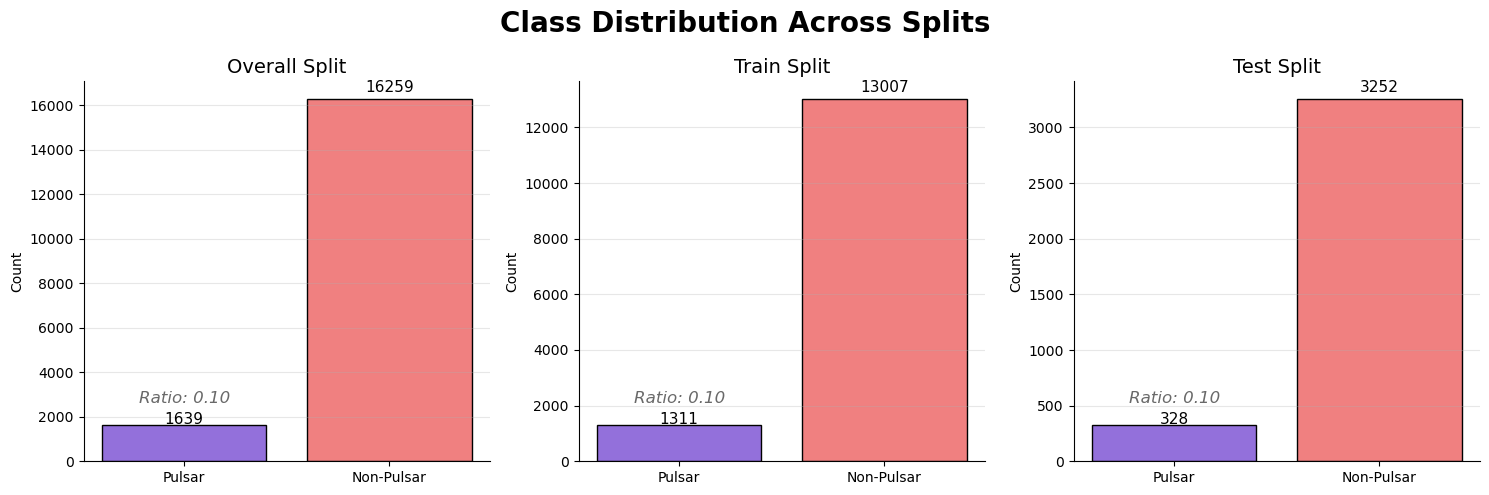

In [5]:
print("Checking stratified splitting...")

overall_counts = pulsar["Target_Class"].value_counts()
train_counts = pulsar_train["Target_Class"].value_counts()
test_counts = pulsar_test["Target_Class"].value_counts()

overall_ratio = overall_counts[1] / overall_counts[0]
train_ratio = train_counts[1] / train_counts[0]
test_ratio = test_counts[1] / test_counts[0]

print(f"Overall ratio: {overall_ratio:.2f}")
print(f"Train ratio:   {train_ratio:.2f}")
print(f"Test ratio:    {test_ratio:.2f}")

pulsar_count_df = pd.DataFrame({
    "Overall": [overall_counts[1], overall_counts[0]],
    "Train": [train_counts[1], train_counts[0]],
    "Test": [test_counts[1], test_counts[0]]
}, index=["Pulsar", "Non-Pulsar"])



fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Class Distribution Across Splits", fontsize=20, fontweight="bold")

ratios = {
    "Overall": overall_ratio,
    "Train": train_ratio,
    "Test": test_ratio
}

for i, split in enumerate(pulsar_count_df.columns):
    axes[i].bar(pulsar_count_df.index, pulsar_count_df[split], color=["mediumpurple", "lightcoral"], edgecolor="black")
    
    axes[i].set_title(f"{split} Split", fontsize=14)
    axes[i].set_ylabel("Count")
    axes[i].grid(axis="y", alpha=0.3)
    axes[i].spines["top"].set_visible(False)
    axes[i].spines["right"].set_visible(False)
    

    for idx, val in enumerate(pulsar_count_df[split]):
        axes[i].text(idx, val + val * 0.02, f"{val}", ha="center", fontsize=11, fontweight="medium")
        if idx == 0: 
            axes[i].text(idx, val * 1.6, f"Ratio: {ratios[split]:.2f}",
                ha="center", fontsize=12, color="dimgray", fontstyle="italic")

plt.tight_layout()
plt.savefig(f"{FIG_PATH}class_distribution_across_splits.png", dpi = 300, bbox_inches = 'tight')
plt.show()

In [6]:
# Let's save the datasets
print("Saving the splitted sets...")
try:
    pulsar_train.to_csv("../data/processed/pulsar_train_set.csv")
    pulsar_test.to_csv("../data/processed/pulsar_test_set.csv")
    print("Splitted sets saved successfully!")

except Exception as e:
    print(f"Saving failed: {e}")

Saving the splitted sets...
Splitted sets saved successfully!


----
# 4. Feature Scaling Experiments

----
As we concluded from our EDA our dataset needs scaling. So in this section we will:
- Apply different scalers
- Visualize scaling effect
- Compare different scalers

In [7]:
print("Separating training feature and target...")

try:
# Training set
    pulsar_train_X = pulsar_train.drop(columns = ["Target_Class"])
    pulsar_train_y = pulsar_train["Target_Class"].copy()

    print("The features and target separated successfully!")
except Exception as e:
    print(f"Separating failed: {e}")
    
print(f"\nPulsar train features shape: {pulsar_train_X.shape}")
print(f"Pulsar train target shape: {pulsar_train_y.shape}")

Separating training feature and target...
The features and target separated successfully!

Pulsar train features shape: (14318, 8)
Pulsar train target shape: (14318,)


## 1. Apply StandardScaler

In [8]:
print("Applying StandardScaler...")

try:
    sd_scaler = StandardScaler()
    pulsar_train_X_sd_scaled = sd_scaler.fit_transform(pulsar_train_X)
    
    pulsar_train_X_sd_scaled_df = pd.DataFrame(
        pulsar_train_X_sd_scaled, 
        columns = pulsar_train_X.columns,
        index = pulsar_train_X.index
    )
    print("StandardScaler applied successfully")
except Exception as e:
    print(f"Scaling failed: {e}")

Applying StandardScaler...
StandardScaler applied successfully


In [9]:
print("Verifying the scaling...")
mean_and_std = pd.DataFrame({
    "Mean": pulsar_train_X_sd_scaled_df.mean().round(4),
    "Std": pulsar_train_X_sd_scaled_df.std().round(4)
})
display(mean_and_std)

Verifying the scaling...


,Mean,Std
Mean_IP,-0.0,1.0
SD_IP,-0.0,1.0
EK_IP,-0.0,1.0
SK_IP,0.0,1.0
Mean_DMSNR,-0.0,1.0
SD_DMSNR,0.0,1.0
EK_DMSNR,-0.0,1.0
SK_DMSNR,0.0,1.0


Visualizing sample before and after StandardScaler...


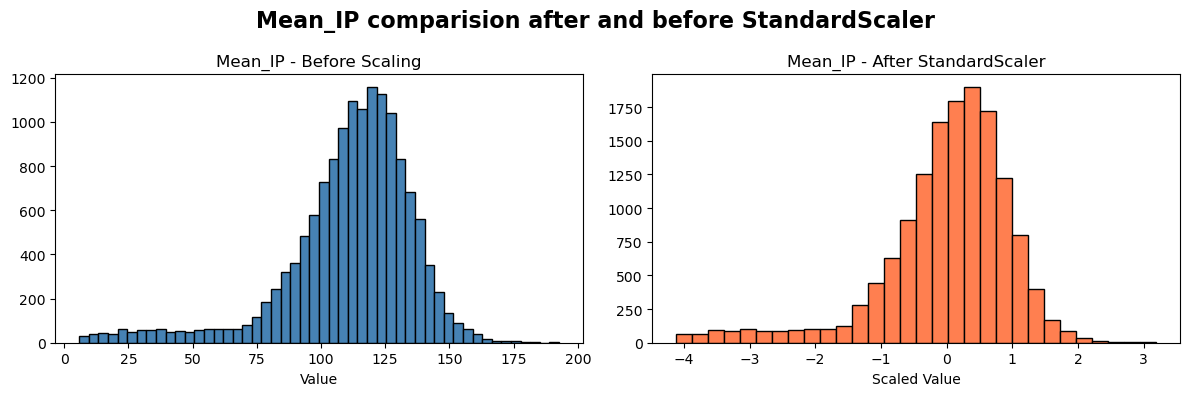

In [10]:
print("Visualizing sample before and after StandardScaler...")
fig, axes = plt.subplots(1, 2, figsize = (12, 4))
fig.suptitle("Mean_IP comparision after and before StandardScaler", fontsize = 16, fontweight = "bold")

axes[0].hist(pulsar_train_X["Mean_IP"], bins = 50, color = 'steelblue', edgecolor = 'black')
axes[0].set_title('Mean_IP - Before Scaling')
axes[0].set_xlabel('Value')

axes[1].hist(pulsar_train_X_sd_scaled_df['Mean_IP'], bins=30, color='coral', edgecolor='black')
axes[1].set_title('Mean_IP - After StandardScaler')
axes[1].set_xlabel('Scaled Value')

plt.tight_layout()
plt.savefig(f"{FIG_PATH}Mean_IP_comparision_after_and_before_StandardScaler.png", dpi = 300, bbox_inches = 'tight')
plt.show()

## 2. Apply RobustScaler

In [11]:
print("Applying RobustScaler...")

try:
    rb_scaler = RobustScaler()
    pulsar_train_X_rb_scaled = rb_scaler.fit_transform(pulsar_train_X)
    
    pulsar_train_X_rb_scaled_df = pd.DataFrame(
        pulsar_train_X_rb_scaled, 
        columns = pulsar_train_X.columns,
        index = pulsar_train_X.index
    )
    print("RobustScaler applied successfully")
except Exception as e:
    print(f"Scaling failed: {e}")

Applying RobustScaler...
RobustScaler applied successfully


In [12]:
print("Verifying the scaling...")
median_and_iqr = pd.DataFrame({
    "Median": pulsar_train_X_rb_scaled_df.median().round(4),
    "IQR": (pulsar_train_X_rb_scaled_df.quantile(0.75) - pulsar_train_X_rb_scaled_df.quantile(0.25)).round(4) 
})
display(median_and_iqr)

Verifying the scaling...


,Median,IQR
Mean_IP,0.0,1.0
SD_IP,-0.0,1.0
EK_IP,0.0,1.0
SK_IP,0.0,1.0
Mean_DMSNR,0.0,1.0
SD_DMSNR,0.0,1.0
EK_DMSNR,-0.0,1.0
SK_DMSNR,-0.0,1.0


Visualizing sample before and after RobustScaler...


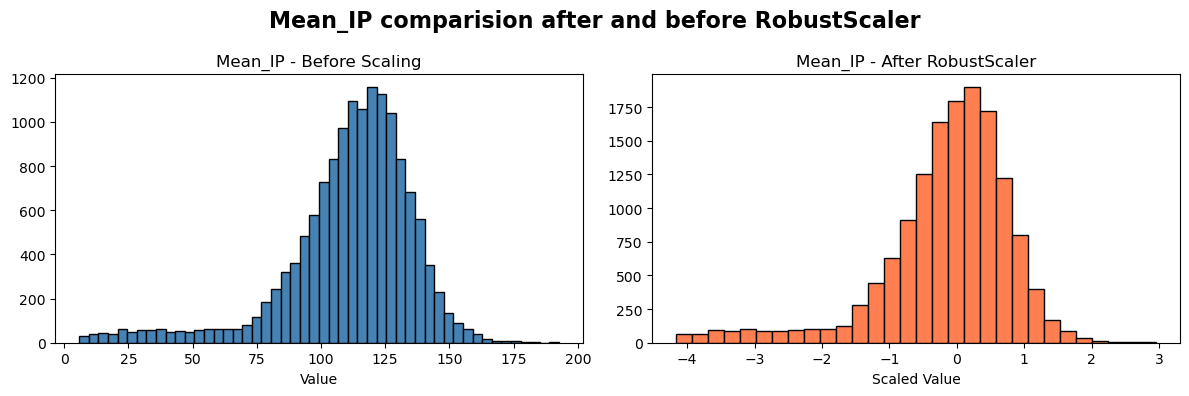

In [13]:
print("Visualizing sample before and after RobustScaler...")
fig, axes = plt.subplots(1, 2, figsize = (12, 4))
fig.suptitle("Mean_IP comparision after and before RobustScaler", fontsize = 16, fontweight = "bold")

axes[0].hist(pulsar_train_X["Mean_IP"], bins = 50, color = 'steelblue', edgecolor = 'black')
axes[0].set_title('Mean_IP - Before Scaling')
axes[0].set_xlabel('Value')

axes[1].hist(pulsar_train_X_rb_scaled_df['Mean_IP'], bins=30, color='coral', edgecolor='black')
axes[1].set_title('Mean_IP - After RobustScaler')
axes[1].set_xlabel('Scaled Value')

plt.tight_layout()
plt.savefig(f"{FIG_PATH}Mean_IP_comparision_after_and_before_RobustScaler.png", dpi = 300, bbox_inches = 'tight')
plt.show()

## 3. Apply MinMaxScaler

In [14]:
print("Applying MinMaxScaler...")

try:
    mm_scaler = MinMaxScaler()
    pulsar_train_X_mm_scaled = mm_scaler.fit_transform(pulsar_train_X)
    
    pulsar_train_X_mm_scaled_df = pd.DataFrame(
        pulsar_train_X_mm_scaled, 
        columns = pulsar_train_X.columns,
        index = pulsar_train_X.index
    )
    print("MinMaxScaler applied successfully")
except Exception as e:
    print(f"Scaling failed: {e}")

Applying MinMaxScaler...
MinMaxScaler applied successfully


In [15]:
print("Verifying the scaling...")
max_and_min = pd.DataFrame({
    "Min": pulsar_train_X_mm_scaled_df.min().round(4),
    "Max": pulsar_train_X_mm_scaled_df.max().round(4)
})
display(max_and_min)

Verifying the scaling...


,Min,Max
Mean_IP,0.0,1.0
SD_IP,0.0,1.0
EK_IP,0.0,1.0
SK_IP,0.0,1.0
Mean_DMSNR,0.0,1.0
SD_DMSNR,0.0,1.0
EK_DMSNR,0.0,1.0
SK_DMSNR,0.0,1.0


Visualizing sample before and after MinMaxScaler...


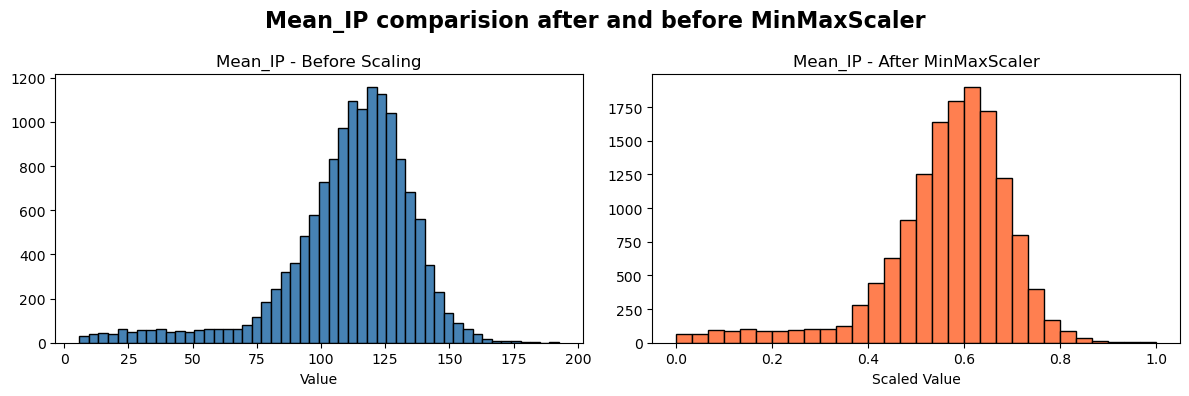

In [16]:
print("Visualizing sample before and after MinMaxScaler...")
fig, axes = plt.subplots(1, 2, figsize = (12, 4))
fig.suptitle("Mean_IP comparision after and before MinMaxScaler", fontsize = 16, fontweight = "bold")

axes[0].hist(pulsar_train_X["Mean_IP"], bins = 50, color = 'steelblue', edgecolor = 'black')
axes[0].set_title('Mean_IP - Before Scaling')
axes[0].set_xlabel('Value')

axes[1].hist(pulsar_train_X_mm_scaled_df['Mean_IP'], bins=30, color='coral', edgecolor='black')
axes[1].set_title('Mean_IP - After MinMaxScaler')
axes[1].set_xlabel('Scaled Value')

plt.tight_layout()
plt.savefig(f"{FIG_PATH}Mean_IP_comparision_after_and_before_MinMaxScaler.png", dpi = 300, bbox_inches = 'tight')
plt.show()

Visualizing all features after and before scaling...


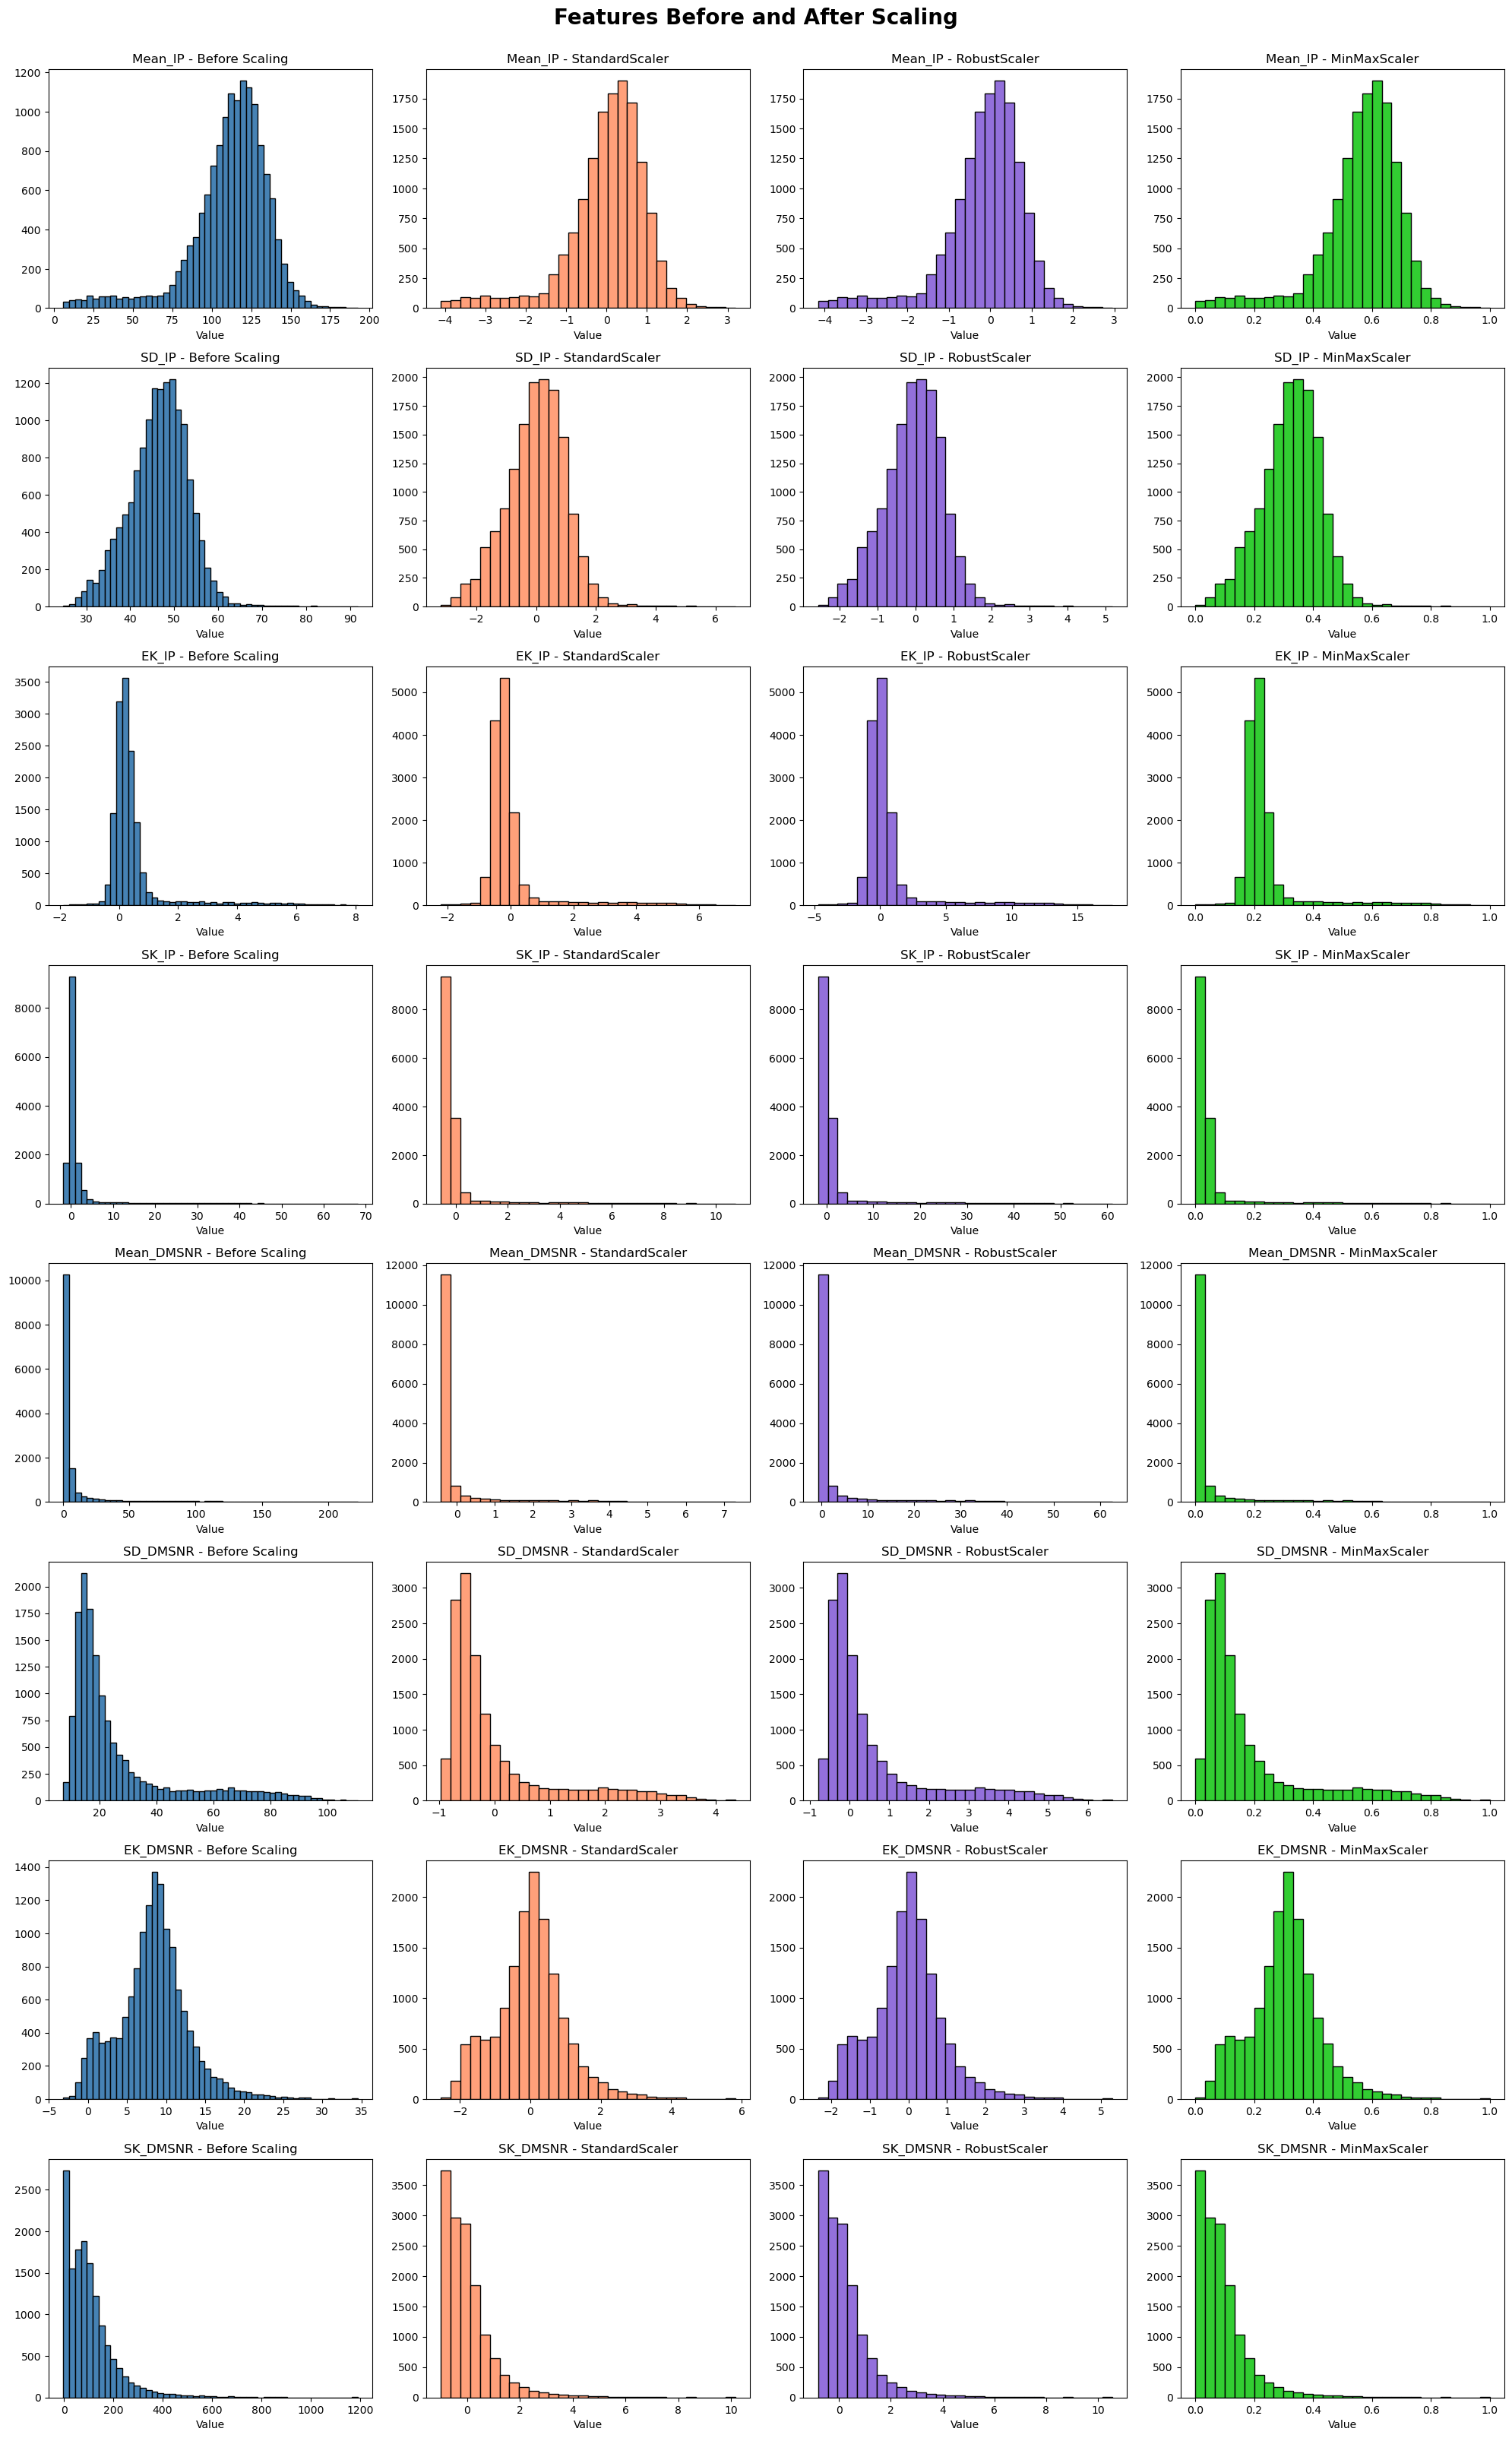

In [17]:
print("Visualizing all features after and before scaling...")
fig, axes = plt.subplots(8, 4, figsize = (20, 32))
fig.suptitle("Features Before and After Scaling", fontsize = 20, fontweight = 'bold', y = 1.001)

for i, feature in enumerate(pulsar_train_X.columns):
    axes[i, 0].hist(pulsar_train_X[feature], bins = 50, color = 'steelblue', edgecolor = 'black')
    axes[i, 0].set_title(f'{feature} - Before Scaling')
    axes[i, 0].set_xlabel('Value')
    
    axes[i, 1].hist(pulsar_train_X_sd_scaled_df[feature], bins=30, color='lightsalmon', edgecolor='black')
    axes[i, 1].set_title(f'{feature} - StandardScaler')
    axes[i, 1].set_xlabel('Value')
    
    axes[i, 2].hist(pulsar_train_X_rb_scaled_df[feature], bins=30, color='mediumpurple', edgecolor='black')
    axes[i, 2].set_title(f'{feature} - RobustScaler')
    axes[i, 2].set_xlabel('Value')
    
    axes[i, 3].hist(pulsar_train_X_mm_scaled_df[feature], bins=30, color='limegreen', edgecolor='black')
    axes[i, 3].set_title(f'{feature} - MinMaxScaler')
    axes[i, 3].set_xlabel('Value')

plt.tight_layout()
plt.savefig(f"{FIG_PATH}before_and after_scaling.png", dpi = 300, bbox_inches = 'tight')
plt.show()

Key takeaways:
- StandardScaler and RobustScaler scalers seems similar for most features
- Since StandardScaler and MinMaxScaler sensetive to outliers, Our main scaler will be RobustScaler
- But different algorithms prefer different scaler so we will build a pipeline including all three scalers as a parameter and fine tune

----
# 5. Feature Tramsformimg Experiment

----
Most models perform well when the data is normal distribution. Since our dataset have many skewed features we will going to handle the skewness of eaxh features. In this section we will:
- Identify skewed features
- Apply transformation to skewed features
- compare skewness befor and after transformation
- Extract key insights

## 5.1 Apply Yeo-Johnson Transformation

In [18]:
print("Applying Yeo-Johnson transformation...")

yeo_johnson = PowerTransformer(method='yeo-johnson', standardize=False)

pulsar_train_X_yj = yeo_johnson.fit_transform(pulsar_train_X)

pulsar_train_X_yj_df = pd.DataFrame(
    pulsar_train_X_yj,
    columns=pulsar_train_X.columns,
    index=pulsar_train_X.index
)

print("Yeo-Johnson transformation applied successfully!")

print("\nSkewness comparison:")
comparison = pd.DataFrame({
    'Original': pulsar_train_X.skew(),
    'Yeo-Johnson': pulsar_train_X_yj_df.skew(),
    'Reduction': pulsar_train_X.skew() - pulsar_train_X_yj_df.skew()
}).round(2)

comparison['Abs_Reduction'] = abs(comparison['Reduction'])
comparison_sorted = comparison.sort_values('Abs_Reduction', ascending=False)
print(comparison_sorted[['Original', 'Yeo-Johnson', 'Reduction']])

Applying Yeo-Johnson transformation...
Yeo-Johnson transformation applied successfully!

Skewness comparison:
            Original  Yeo-Johnson  Reduction
SK_IP           5.20        -0.22       5.43
EK_IP           3.66        -1.02       4.68
Mean_DMSNR      3.70         0.25       3.45
SK_DMSNR        2.71        -0.03       2.74
SD_DMSNR        1.90         0.15       1.76
Mean_IP        -1.38        -0.10      -1.28
EK_DMSNR        0.45         0.04       0.41
SD_IP           0.04         0.04      -0.00


Visualizing Yeo-Johnson transformation impact...


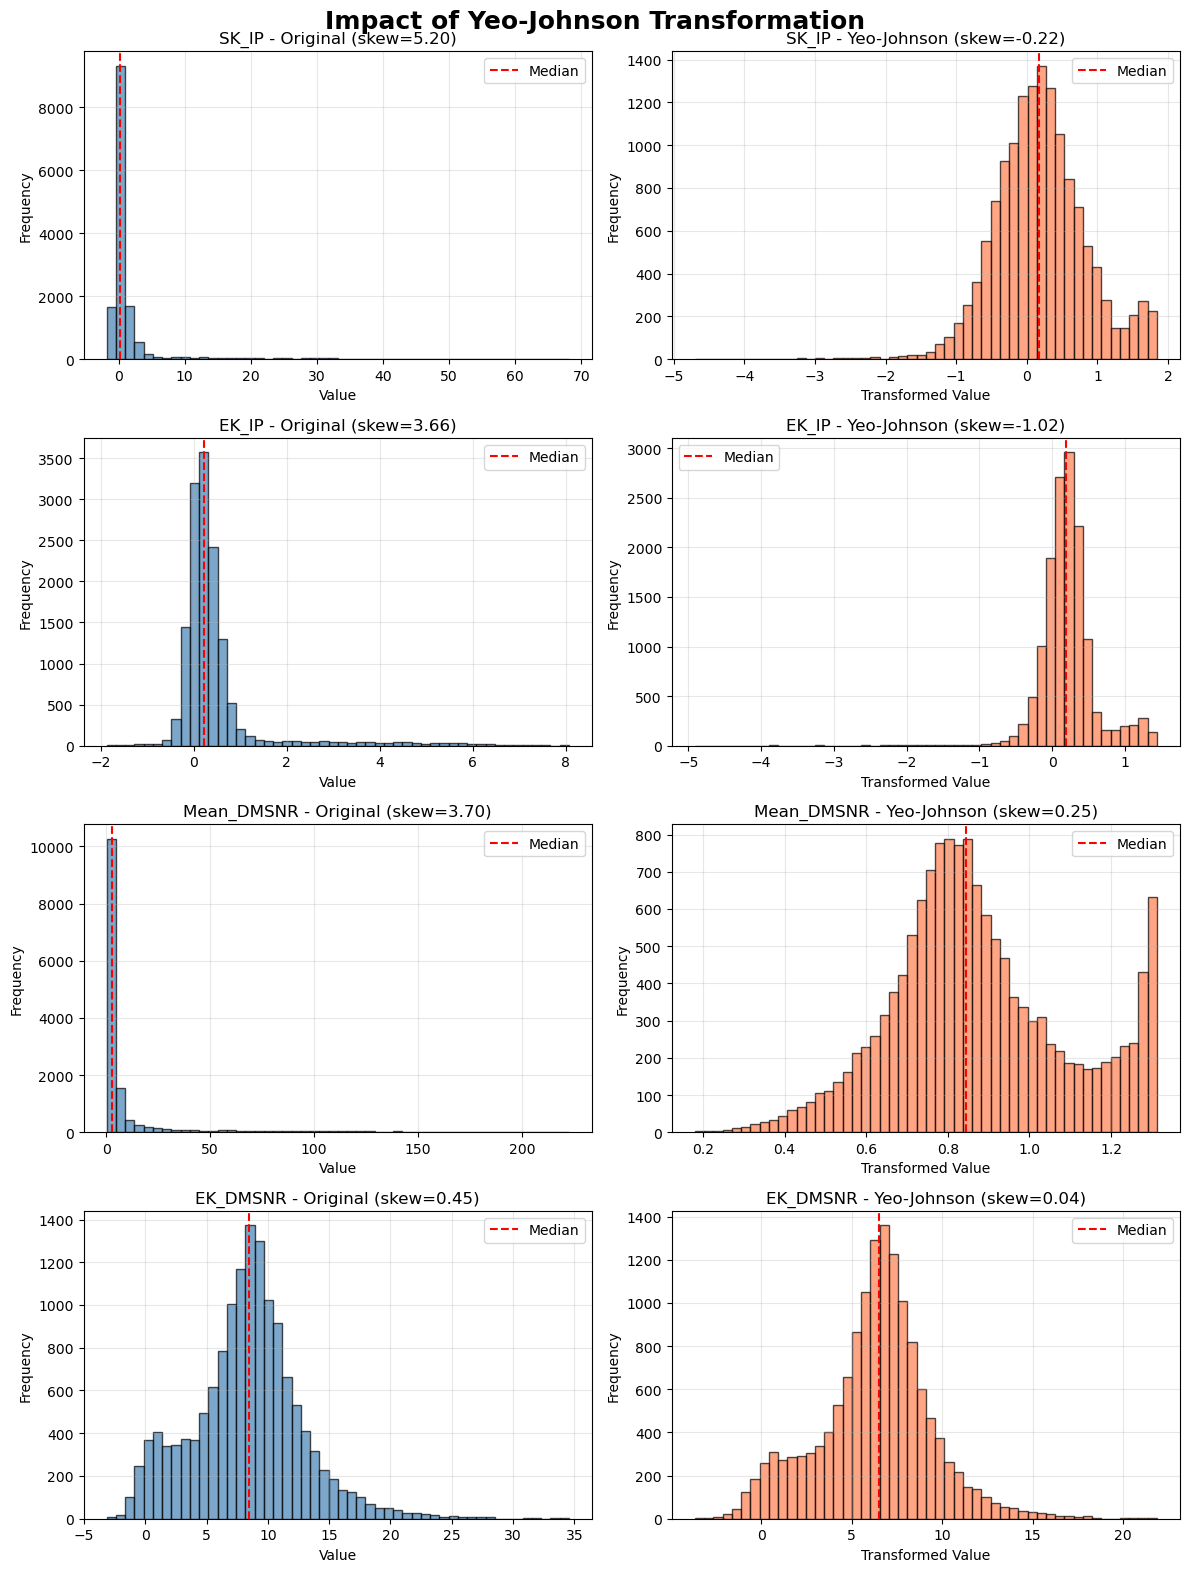

In [19]:
print("Visualizing Yeo-Johnson transformation impact...")

features_to_plot = [
    'SK_IP',     
    'EK_IP',      
    'Mean_DMSNR', 
    'EK_DMSNR',   
]

fig, axes = plt.subplots(len(features_to_plot), 2, figsize=(12, 16))
fig.suptitle('Impact of Yeo-Johnson Transformation', fontsize=18, fontweight='bold')

for i, feature in enumerate(features_to_plot):
    skew_orig = pulsar_train_X[feature].skew()
    skew_yj = pulsar_train_X_yj_df[feature].skew()
    
    # Before
    axes[i, 0].hist(pulsar_train_X[feature], bins=50, 
                    color='steelblue', edgecolor='black', alpha=0.7)
    axes[i, 0].set_title(f'{feature} - Original (skew={skew_orig:.2f})')
    axes[i, 0].set_xlabel('Value')
    axes[i, 0].set_ylabel('Frequency')
    axes[i, 0].grid(alpha=0.3)
    axes[i, 0].axvline(pulsar_train_X[feature].median(), 
                       color='red', linestyle='--', label='Median')
    axes[i, 0].legend()
    
    # After
    axes[i, 1].hist(pulsar_train_X_yj_df[feature], bins=50, 
                    color='coral', edgecolor='black', alpha=0.7)
    axes[i, 1].set_title(f'{feature} - Yeo-Johnson (skew={skew_yj:.2f})')
    axes[i, 1].set_xlabel('Transformed Value')
    axes[i, 1].set_ylabel('Frequency')
    axes[i, 1].grid(alpha=0.3)
    axes[i, 1].axvline(pulsar_train_X_yj_df[feature].median(), 
                       color='red', linestyle='--', label='Median')
    axes[i, 1].legend()

plt.tight_layout()
plt.savefig(f"{FIG_PATH}yeo_johnson_transformation_impact.png", 
            dpi=300, bbox_inches='tight')
plt.show()

## 5.2 Cube Root Transformation

In [20]:
print("Applying Cube Root transformation for comparison...")

pulsar_train_X_cbrt_df = pulsar_train_X.apply(np.cbrt)

print("\nCube Root Skewness:")
comparison_cbrt = pd.DataFrame({
    'Original': pulsar_train_X.skew(),
    'Cube_Root': pulsar_train_X_cbrt_df.skew(),
    'Yeo_Johnson': pulsar_train_X_yj_df.skew()
}).round(2)

print(comparison_cbrt)

Applying Cube Root transformation for comparison...

Cube Root Skewness:
            Original  Cube_Root  Yeo_Johnson
Mean_IP        -1.38      -2.64        -0.10
SD_IP           0.04      -0.37         0.04
EK_IP           3.66      -0.47        -1.02
SK_IP           5.20       0.61        -0.22
Mean_DMSNR      3.70       2.27         0.25
SD_DMSNR        1.90       1.29         0.15
EK_DMSNR        0.45      -2.62         0.04
SK_DMSNR        2.71      -0.84        -0.03


Key takeaways:
- Different models prefer different preprocessing! By testing systematically,   
- we let the data decide rather than making assumptions.  

----
# 6. Feature Engineering

----

## 6.1 Create Interaction Features

In [21]:
print("Creating Interaction Features...")

pulsar_train_X_engineered = pulsar_train_X.copy()

# Interaction 1
pulsar_train_X_engineered['Profile_Consistency'] = (
    pulsar_train_X['Mean_IP'] * pulsar_train_X['SD_IP']
)
print("\nCreated: Profile_Consistency = Mean_IP × SD_IP")

# Interaction 2
pulsar_train_X_engineered['Profile_Shape'] = (
    pulsar_train_X['EK_IP'] * pulsar_train_X['SK_IP']
)
print("Created: Profile_Shape = EK_IP × SK_IP")

# Interaction 3
epsilon = 1e-8
pulsar_train_X_engineered['DMSNR_Quality'] = (
    pulsar_train_X['Mean_DMSNR'] / 
    (pulsar_train_X['SD_DMSNR'] + epsilon)
)
print("Created: DMSNR_Quality = Mean_DMSNR / SD_DMSNR")

# Interaction 4
pulsar_train_X_engineered['Cross_Signal'] = (
    pulsar_train_X['Mean_IP'] * pulsar_train_X['Mean_DMSNR']
)
print("Created: Cross_Signal = Mean_IP × Mean_DMSNR")

# Interaction 5
pulsar_train_X_engineered['Profile_CV'] = (
    pulsar_train_X['SD_IP'] / 
    (abs(pulsar_train_X['Mean_IP']) + epsilon)
)
print("reated: Profile_CV = SD_IP / Mean_IP")

pulsar_train_X_engineered['DMSNR_Shape'] = (
    pulsar_train_X['EK_DMSNR'] * pulsar_train_X['SK_DMSNR']
)
print("Created: DMSNR_Shape = EK_DMSNR × SK_DMSNR")

print(f"\nFeature count: {pulsar_train_X.shape[1]} to {pulsar_train_X_engineered.shape[1]}")
print(f"  (Original: 8, Added: {pulsar_train_X_engineered.shape[1] - 8}, Total: {pulsar_train_X_engineered.shape[1]})")

Creating Interaction Features...

Created: Profile_Consistency = Mean_IP × SD_IP
Created: Profile_Shape = EK_IP × SK_IP
Created: DMSNR_Quality = Mean_DMSNR / SD_DMSNR
Created: Cross_Signal = Mean_IP × Mean_DMSNR
reated: Profile_CV = SD_IP / Mean_IP
Created: DMSNR_Shape = EK_DMSNR × SK_DMSNR

Feature count: 8 to 14
  (Original: 8, Added: 6, Total: 14)


Visualizing Interaction Features by Class...


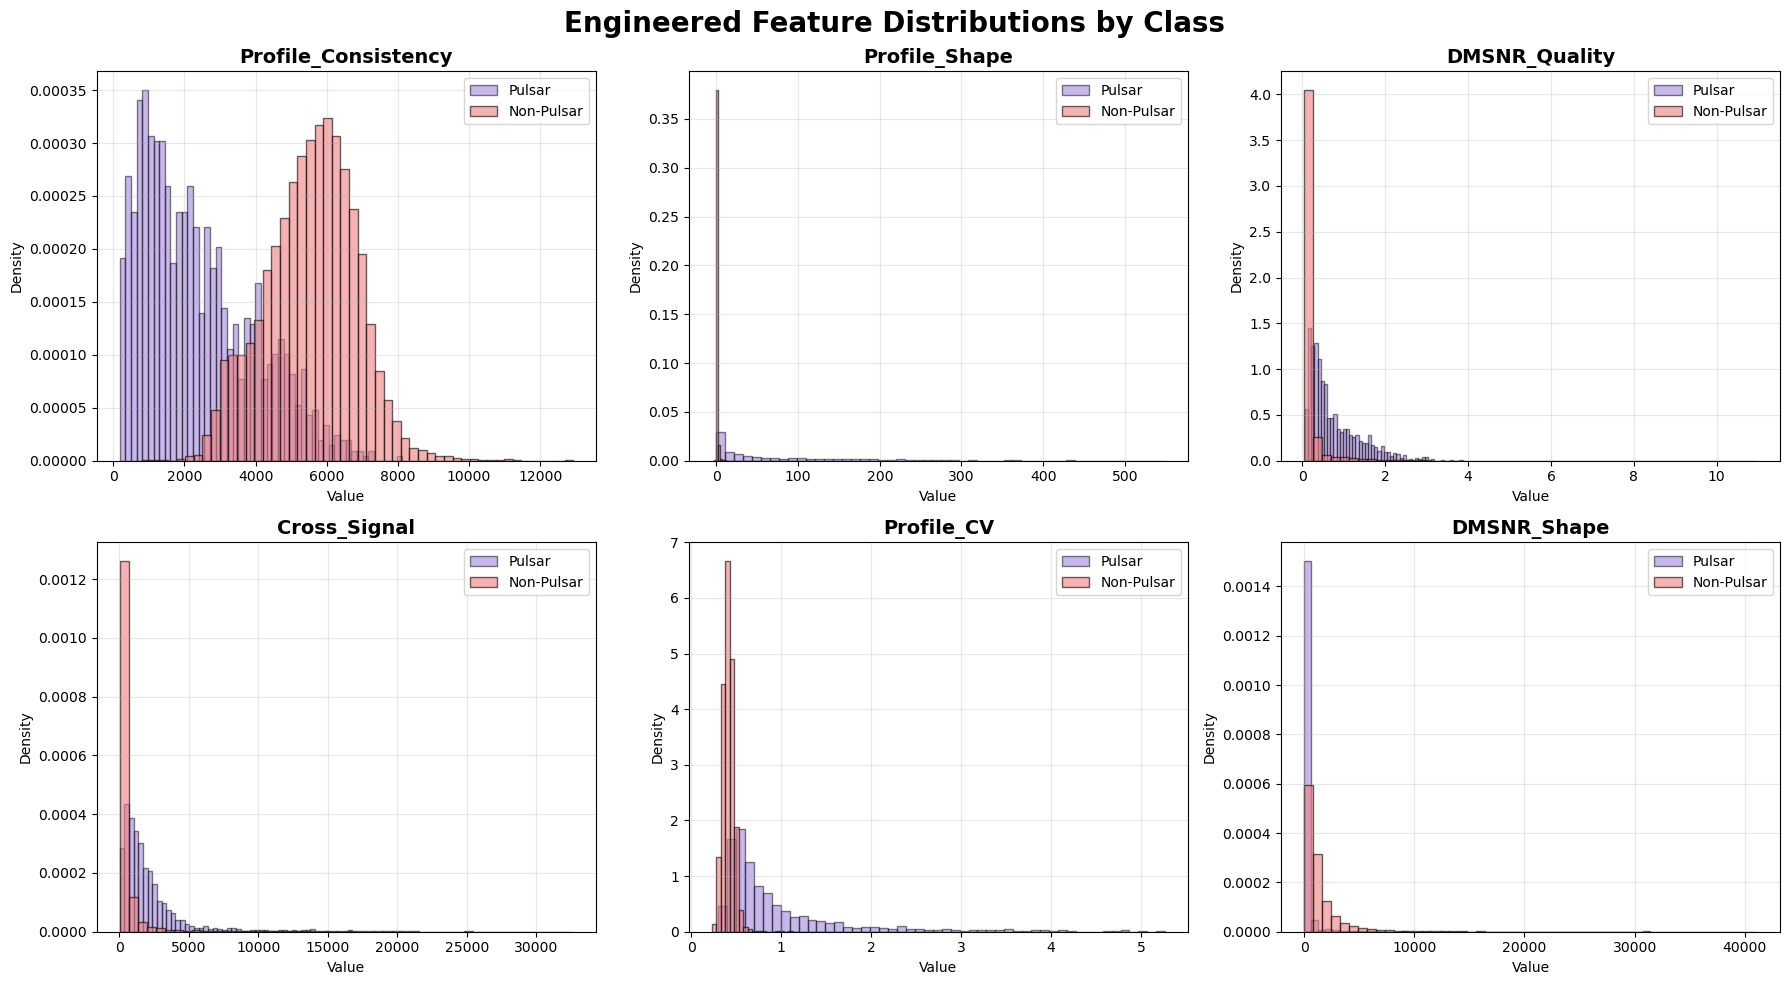

In [22]:
print("Visualizing Interaction Features by Class...")

new_features = [col for col in pulsar_train_X_engineered.columns 
                if col not in pulsar_train_X.columns]

pulsar_class = pulsar_train_y == 1
non_pulsar_class = pulsar_train_y == 0

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Engineered Feature Distributions by Class', 
             fontsize=20, fontweight='bold')
axes = axes.flatten()

for i, feature in enumerate(new_features):
    axes[i].hist(pulsar_train_X_engineered.loc[pulsar_class, feature], bins=50, alpha=0.5, label='Pulsar', 
                 color='mediumpurple', density=True, edgecolor='black')
    
    axes[i].hist(pulsar_train_X_engineered.loc[non_pulsar_class, feature], bins=50, alpha=0.6, label='Non-Pulsar', 
                 color='lightcoral', density=True, edgecolor='black')
    
    axes[i].set_title(feature, fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Density')
    axes[i].legend()
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f"{FIG_PATH}engineered_features_by_class.png", dpi=300, bbox_inches='tight')
plt.show()

key takeaways:
- Profile_Consistency, Profile_CV, and profile shape are the top 3 engineered features
- WE will keep all 3 features and let the models chose importance features

---
## 7. Class Imbalance Handling Strategy

----
Our dataset has 91:9 imbalance.

***Strategies to Test:***

**1. Class Weights (Baseline)**
- Set `class_weight='balanced'` in sklearn models
- Automatically weights loss function
- For XGBoost: `scale_pos_weight = 91/9 `

**2. SMOTE (Synthetic Minority Over-sampling)**
- Generates synthetic pulsar samples
- Apply ONLY during cross-validation (inside each fold)

**3. Combined Approach**
- SMOTE + Class Weights
- SMOTE-Tomek (oversampling + cleaning)

***Implementation Strategy:***
- We will test ALL strategies during hyperparameter tuning.
- Cross-validation will reveal which works best for each model type.

----
## 9. Feature Engineering Summary

----
***Data Preparation:***
- Loaded 17,898 samples (8 features, 1 target)
- Stratified 80/20 train/test split (14,318 / 3,580)
- Verified class balance maintained (91:9 in both splits)

***Feature Scaling Comparison:***
- Tested StandardScaler, RobustScaler, MinMaxScaler
- Decision: Use RobustScaler as default (handles outliers better)
- Strategy: Test all three scalers in pipeline hyperparameter tuning

***Feature Transformation:***
- Applied Yeo-Johnson transformation to all features
- Results: Reduced skewness from 5.2 to -0.22 (SK_IP), 3.7 to 0.25 (Mean_DMSNR)
- Successfully handled negative values (EK features)

***Feature Engineering:***
- Created 6 interaction features
- Top performers: Profile_Shape, Profile_CV, Profile_Consistency
- Decision: Keep all 14 features (8 + 6), let models select

***Class Imbalance Strategy:***
- Documented three strategies: Class Weights, SMOTE, Combined
- Will test all during model training


***Key Insights:***
- Yeo-Johnson successfully normalized heavily skewed features
- Engineered features show strong discriminative power
- RobustScaler best choice for outlier-heavy features
- Strategic decision to let models perform feature selection